# DEMAND FORECASTING

### Impoting libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import chart_studio.plotly as py

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(1)


### Loading the Data

In [2]:
train = pd.read_csv("demand_dataset/train_0irEZ2H.csv", parse_dates=['week'])
test = pd.read_csv('demand_dataset/best_nfaJ3J5.csv', parse_dates=['week'])


In [3]:
train.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


### Checking null values

In [4]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

### Dropping Null Values

In [5]:
train=train.dropna(how='any')

In [6]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [7]:
print('Min date from train set: %s' % train['week'].min().date())
print('Max date from train set: %s' % train['week'].max().date())

Min date from train set: 2011-01-08
Max date from train set: 2013-12-03


In [8]:
lag_size = (test['week'].max().date() - train['week'].max().date()).days
print('Max date from train set: %s' % train['week'].max().date())
print('Max date from test set: %s' % test['week'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2013-12-03
Max date from test set: 2013-10-09
Forecast lag size -55


### EDA

##### Daily Sales

In [9]:
daily_sales = train.groupby('week', as_index=False)['units_sold'].sum()
store_daily_sales = train.groupby(['store_id', 'week'], as_index=False)['units_sold'].sum()
item_daily_sales = train.groupby(['sku_id', 'week'], as_index=False)['units_sold'].sum()

In [10]:
daily_sales_sc = go.Scatter(x=daily_sales['week'], y=daily_sales['units_sold'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

##### Daily Sales with respect to stores

In [11]:
store_daily_sales_sc = []
for store in store_daily_sales['store_id'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store_id'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['week'], y=current_store_daily_sales['units_sold'], name=('Store_id %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

## Preprocessing

## Rearranging Dataset for applying Shift Method

In [12]:
train_gp = train.sort_values('week').groupby(['sku_id', 'store_id', 'week'], as_index=False)
train_gp = train_gp.agg({'units_sold':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,216233,8023,2011-01-08,119.0
1,216233,8023,2011-01-17,114.0
2,216233,8023,2011-01-24,87.0
3,216233,8023,2011-01-31,135.0
4,216233,8023,2011-02-05,98.0


## Transforming data into time series problem

In [13]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We will use the current timestep and the last 29 to forecast 90 days ahead

In [14]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+-55),store(t+-55),sales(t+-55)
55,216233.0,8023.0,130.0,216233.0,8023.0,124.0,216233.0,8023.0,106.0,216233.0,...,101.0,216233.0,8023.0,22.0,216233,8023,131.0,216233.0,8023.0,119.0
56,216233.0,8023.0,124.0,216233.0,8023.0,106.0,216233.0,8023.0,117.0,216233.0,...,22.0,216233.0,8023.0,131.0,216233,8023,158.0,216233.0,8023.0,114.0
57,216233.0,8023.0,106.0,216233.0,8023.0,117.0,216233.0,8023.0,186.0,216233.0,...,131.0,216233.0,8023.0,158.0,216233,8023,151.0,216233.0,8023.0,87.0
58,216233.0,8023.0,117.0,216233.0,8023.0,186.0,216233.0,8023.0,147.0,216233.0,...,158.0,216233.0,8023.0,151.0,216233,8023,163.0,216233.0,8023.0,135.0
59,216233.0,8023.0,186.0,216233.0,8023.0,147.0,216233.0,8023.0,145.0,216233.0,...,151.0,216233.0,8023.0,163.0,216233,8023,127.0,216233.0,8023.0,98.0


#### Drop rows with different item or store values than the shifted columns

In [15]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

### Remove unwanted columns

In [16]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

### Train/validation split

In [17]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (69976, 30)
Validation set shape (46652, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
74017,54.0,109.0,50.0,78.0,65.0,57.0,41.0,47.0,33.0,42.0,...,39.0,103.0,35.0,38.0,41.0,62.0,56.0,82.0,33.0,47.0
41205,40.0,30.0,54.0,77.0,46.0,52.0,28.0,30.0,35.0,36.0,...,54.0,52.0,46.0,61.0,102.0,77.0,31.0,32.0,45.0,75.0
16102,126.0,113.0,233.0,127.0,100.0,113.0,123.0,101.0,87.0,152.0,...,146.0,97.0,130.0,98.0,100.0,147.0,138.0,119.0,99.0,130.0
75709,15.0,18.0,20.0,11.0,21.0,17.0,15.0,28.0,19.0,17.0,...,29.0,26.0,15.0,40.0,29.0,41.0,17.0,37.0,21.0,20.0
23213,60.0,51.0,73.0,46.0,62.0,56.0,31.0,138.0,79.0,95.0,...,30.0,33.0,25.0,30.0,26.0,31.0,25.0,22.0,77.0,33.0


### MLP for Time Series Forecasting

In [18]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)


In [19]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
2187/2187 - 2s - 864us/step - loss: 3092.8569 - val_loss: 2715.0603
Epoch 2/40
2187/2187 - 2s - 694us/step - loss: 2600.5508 - val_loss: 2556.5330
Epoch 3/40
2187/2187 - 1s - 646us/step - loss: 2444.1731 - val_loss: 2428.4795
Epoch 4/40
2187/2187 - 1s - 603us/step - loss: 2309.9402 - val_loss: 2315.8740
Epoch 5/40
2187/2187 - 1s - 617us/step - loss: 2203.5098 - val_loss: 2231.0015
Epoch 6/40
2187/2187 - 1s - 604us/step - loss: 2118.8992 - val_loss: 2164.4509
Epoch 7/40
2187/2187 - 1s - 608us/step - loss: 2053.5852 - val_loss: 2111.5435
Epoch 8/40
2187/2187 - 1s - 628us/step - loss: 2002.6299 - val_loss: 2072.4690
Epoch 9/40
2187/2187 - 1s - 609us/step - loss: 1959.8206 - val_loss: 2038.9515
Epoch 10/40
2187/2187 - 1s - 604us/step - loss: 1924.8401 - val_loss: 2010.6549
Epoch 11/40
2187/2187 - 1s - 612us/step - loss: 1894.1794 - val_loss: 1990.8909
Epoch 12/40
2187/2187 - 1s - 603us/step - loss: 1867.3486 - val_loss: 1972.4629
Epoch 13/40
2187/2187 - 1s - 641us/step - loss: 1

### Evaluation

In [21]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step
Train rmse: 39.48793520238504
Validation rmse: 42.34307900838299


# INVENTORY OPTIMIZATION

## Importing libraries

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

## Loading the data

In [22]:
df_inventory_control = pd.read_excel("inventory_datset\Dynamic Inventory Analytics.xlsx", sheet_name='Inventory Control')
df_sku_items = pd.read_excel("inventory_datset\Dynamic Inventory Analytics.xlsx", sheet_name='SKU Items')
df_sales_data = pd.read_excel("inventory_datset\Dynamic Inventory Analytics.xlsx", sheet_name='Sales Data')
df_warehouse = pd.read_excel("inventory_datset\Dynamic Inventory Analytics.xlsx", sheet_name='Warehouse')

## Feature Engineering

In [23]:
df_sales_data['Order Quantity'] = df_sales_data['Order Quantity'].astype(int)
df_sales_data['day'] = df_sales_data['Order Date'].dt.day
df_sales_data['month'] = df_sales_data['Order Date'].dt.month
df_sales_data['year'] = df_sales_data['Order Date'].dt.year
df_sales_data['Order Date'] = pd.to_datetime(df_sales_data['Order Date'])
df_sales_data.drop(['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis=1, inplace=True)

df_sales_data['Avg Sales Per Day'] = df_sales_data.groupby(['SKU ID', 'Warehouse ID', 'Order Date'])['Order Quantity'].transform('mean')
df_sales_data['Max Sales Per Day'] = df_sales_data.groupby(['SKU ID', 'Warehouse ID', 'Order Date'])['Order Quantity'].transform('max')

df_inventory_control['Current Inventory Quantity'] = df_inventory_control['Current Inventory Quantity'].astype(int)

df_inventory_control.head(20)

,SKU ID,Vendor Name,Warehouse ID,Current Inventory Quantity,Cost per SKU,Total Value,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price
0,1009AA,McKesson Corp,NXH382,7210,20.134282,1.451682e+05,Kg,30,48,28.76326
1,1077CA,McKesson Corp,GUT930,46516,16.084390,7.481815e+05,Kg,45,70,22.97770
2,1083AA,Kinray Ltd,FLR025,48210,20.314000,9.793379e+05,Kg,45,68,29.02000
3,1116CA,Accord Ltd,AXW291,33398,22.960000,7.668181e+05,Kg,90,140,32.80000
4,1126CA,AstraZeneca,NXH382,39270,22.960000,9.016392e+05,Kg,45,62,32.80000
5,1130AA,Sun Ltd,GUT930,13622,12.086263,1.646391e+05,Kg,90,139,17.26609
6,1145BA,Mylan Group,FLR025,1816,59.710462,1.084342e+05,Kg,45,60,85.30066
7,1161AA,Kinray Ltd,NXH382,197,95.614750,1.883611e+04,Kg,90,142,136.59250
8,1163CA,Macoven Group,NXH382,2161,66.264975,1.431986e+05,Kg,90,136,94.66425
9,1193BA,Major Corp,AXW291,2957,570.500000,1.686968e+06,Kg,90,138,815.00000


In [24]:
df_inventory = df_inventory_control.merge(df_sales_data[['SKU ID', 'Warehouse ID', 'Avg Sales Per Day', 'Max Sales Per Day']], left_on=['SKU ID', 'Warehouse ID'], right_on=['SKU ID', 'Warehouse ID'])
df_inventory['Optimal Stock Level'] = df_inventory['Avg Sales Per Day'] * df_inventory['Average Lead Time (days)']
df_inventory['Safety Stock'] = df_inventory['Max Sales Per Day'] - df_inventory['Avg Sales Per Day']
df_inventory['Recommended Stock Level'] = df_inventory['Optimal Stock Level'] + df_inventory['Safety Stock']
df_inventory['Order Quantity'] = df_inventory['Recommended Stock Level'] - df_inventory['Current Inventory Quantity']
df_inventory['Order Quantity'] = df_inventory['Order Quantity'].clip(lower=0)
df_inventory.head(10)

,SKU ID,Vendor Name,Warehouse ID,Current Inventory Quantity,Cost per SKU,Total Value,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price,Avg Sales Per Day,Max Sales Per Day,Optimal Stock Level,Safety Stock,Recommended Stock Level,Order Quantity
0,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,140.0,140,4200.0,0.0,4200.0,0.0
1,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,40.0,40,1200.0,0.0,1200.0,0.0
2,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,70.0,70,2100.0,0.0,2100.0,0.0
3,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,420.0,420,12600.0,0.0,12600.0,5390.0
4,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,85.0,85,2550.0,0.0,2550.0,0.0
5,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,192.0,192,5760.0,0.0,5760.0,0.0
6,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,1375.0,1375,41250.0,0.0,41250.0,34040.0
7,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,305.0,305,9150.0,0.0,9150.0,1940.0
8,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,284.0,305,8520.0,21.0,8541.0,1331.0
9,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.1732,Kg,30,48,28.76326,284.0,305,8520.0,21.0,8541.0,1331.0


In [25]:
sum_values = df_inventory.groupby(['SKU ID', 'Warehouse ID', 'Current Inventory Quantity'])['Recommended Stock Level'].mean().reset_index()
sum_values.sort_values(by='SKU ID', ascending=False).head(20)

,SKU ID,Warehouse ID,Current Inventory Quantity,Recommended Stock Level
284,3619CA,NXH382,36357,38161.906250
283,3616CA,GUT930,331,1045.714286
282,3610AA,GUT930,275,3154.285714
281,3590BA,NXH382,145,1014.545455
280,3579CA,GUT930,116,6080.000000
279,3576BA,GUT930,162,1077.600000
278,3570CA,NXH382,416,954.000000
277,3556AA,NXH382,262,1038.750000
276,3551CA,FLR025,10034,8108.235294
275,3533CA,GUT930,82476,115622.894737


### PREPROCESSING

In [26]:
df_inventory

,SKU ID,Vendor Name,Warehouse ID,Current Inventory Quantity,Cost per SKU,Total Value,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price,Avg Sales Per Day,Max Sales Per Day,Optimal Stock Level,Safety Stock,Recommended Stock Level,Order Quantity
0,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.17320,Kg,30,48,28.76326,140.0,140,4200.0,0.0,4200.0,0.0
1,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.17320,Kg,30,48,28.76326,40.0,40,1200.0,0.0,1200.0,0.0
2,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.17320,Kg,30,48,28.76326,70.0,70,2100.0,0.0,2100.0,0.0
3,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.17320,Kg,30,48,28.76326,420.0,420,12600.0,0.0,12600.0,5390.0
4,1009AA,McKesson Corp,NXH382,7210,20.134282,145168.17320,Kg,30,48,28.76326,85.0,85,2550.0,0.0,2550.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,3619CA,Allermed Group,NXH382,36357,0.521850,18972.90045,Kg,15,22,0.74550,2132.0,2132,31980.0,0.0,31980.0,0.0
8706,3619CA,Allermed Group,NXH382,36357,0.521850,18972.90045,Kg,15,22,0.74550,16527.0,16527,247905.0,0.0,247905.0,211548.0
8707,3619CA,Allermed Group,NXH382,36357,0.521850,18972.90045,Kg,15,22,0.74550,1000.0,1000,15000.0,0.0,15000.0,0.0
8708,3619CA,Allermed Group,NXH382,36357,0.521850,18972.90045,Kg,15,22,0.74550,1320.0,1320,19800.0,0.0,19800.0,0.0


In [27]:
print(f"Number of unique products: {df_inventory_control['SKU ID'].nunique()}")
df_inventory_control['SKU ID'].value_counts().sort_values(ascending=False).head(20)

Number of unique products: 303


1009AA    1
1281BA    1
1083AA    1
1116CA    1
1126CA    1
1130AA    1
1145BA    1
1161AA    1
1163CA    1
1193BA    1
1196AA    1
1206BA    1
1214CA    1
1224AA    1
1234BA    1
1244AA    1
1255CA    1
1265CA    1
1382CA    1
1712AA    1
Name: SKU ID, dtype: int64

In [28]:
df_sales_data.head(20)

,Order Number,Order Date,SKU ID,Warehouse ID,Customer Type,Order Quantity,Unit Sale Price,Revenue,day,month,year,Avg Sales Per Day,Max Sales Per Day
0,SO - 018900,2021-01-01,3551CA,GUT930,Export,105,7.06831,742,1,1,2021,302.5,500
1,SO - 018901,2021-01-01,3079BA,AXW291,Wholesale,151,134.50000,20310,1,1,2021,151.0,151
2,SO - 018902,2021-01-01,3250CA,AXW291,Distributor,300,34.75342,10426,1,1,2021,900.0,1500
3,SO - 018903,2021-01-01,1161AA,GUT930,Wholesale,50,136.59250,6830,1,1,2021,50.0,50
4,SO - 018904,2021-01-01,3512AA,GUT930,Distributor,1000,0.10295,103,1,1,2021,1000.0,1000
5,SO - 018905,2021-01-01,1741BA,AXW291,Distributor,6,1450.00000,8700,1,1,2021,4.5,6
6,SO - 018906,2021-01-01,3462AA,NXH382,Wholesale,50,4.10000,205,1,1,2021,50.0,50
7,SO - 018907,2021-01-01,3590BA,GUT930,Distributor,25,115.08500,2877,1,1,2021,25.0,25
8,SO - 018908,2021-01-01,3551CA,AXW291,Distributor,98,7.06831,693,1,1,2021,79.0,98
9,SO - 018909,2021-01-01,1479CA,FLR025,Export,3,385.56250,1157,1,1,2021,3.0,3


In [29]:
print(f"Number of unique products: {df_sales_data['SKU ID'].nunique()}")
df_sales_data['SKU ID'].value_counts().sort_values(ascending=False).head(20)

Number of unique products: 290


3178CA    361
3205AA    356
3271CA    355
3239AA    345
3264CA    345
3180BA    345
3249CA    345
1497CA    326
2501CA    234
3404CA    231
3533CA    226
1009AA    222
2336BA    213
2317CA    213
3075BA    210
1283CA    208
1479CA    208
2923CA    207
1403CA    202
1584BA    199
Name: SKU ID, dtype: int64

In [30]:
start_date = df_sales_data['Order Date'].min()
end_date = df_sales_data['Order Date'].max()

print(start_date)
print(end_date)

2021-01-01 00:00:00
2023-07-30 00:00:00


## EDA

### Quantity per item

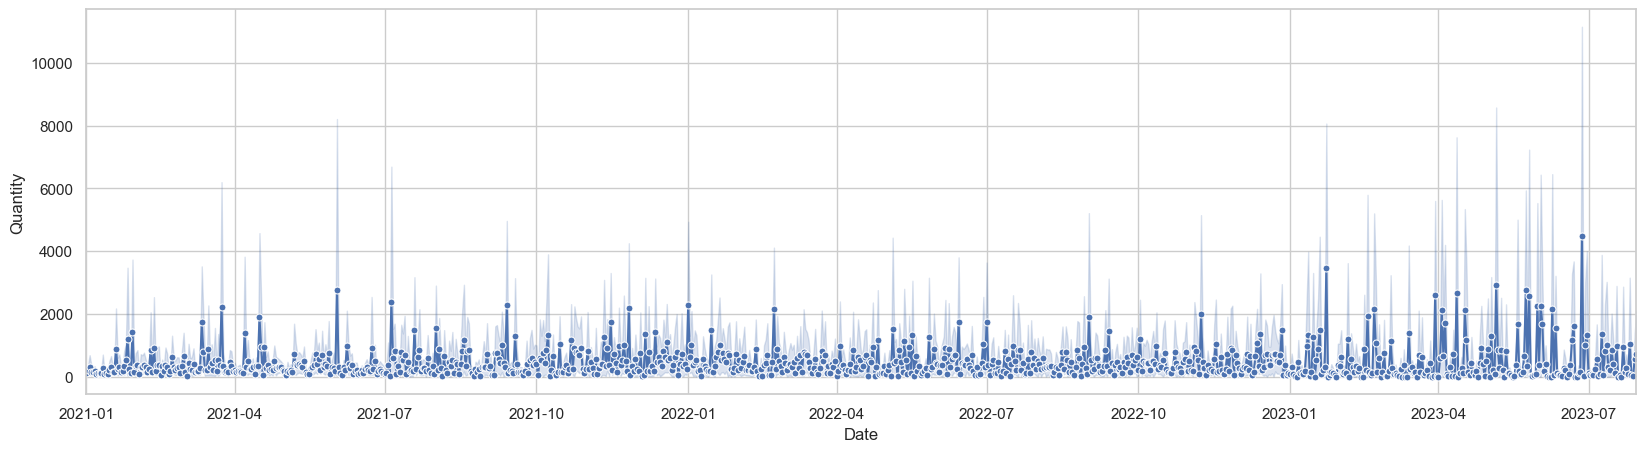

In [31]:
fig, ax = plt.subplots(figsize=(20,5))

sns.lineplot(x=df_sales_data['Order Date'], y=df_sales_data['Order Quantity'], marker='o', markersize=5)

ax.set_xlim([start_date, end_date])

ax.set_xlabel("Date")
ax.set_ylabel("Quantity");

In [32]:
quantity_per_warehouse = df_sales_data.groupby(['SKU ID', 'year'])['Order Quantity'].sum().reset_index()
quantity_per_warehouse.sort_values(by=['SKU ID', 'Order Quantity'], ascending=False).head(20)

,SKU ID,year,Order Quantity
854,3619CA,2021,269793
855,3619CA,2022,211335
856,3619CA,2023,23021
851,3616CA,2021,462
852,3616CA,2022,195
853,3616CA,2023,8
848,3610AA,2021,361
849,3610AA,2022,200
850,3610AA,2023,21
845,3590BA,2021,894


In [33]:
df_inventory_control[df_inventory_control['SKU ID']=='3619CA']

,SKU ID,Vendor Name,Warehouse ID,Current Inventory Quantity,Cost per SKU,Total Value,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price
302,3619CA,Allermed Group,NXH382,36357,0.52185,18972.90045,Kg,15,22,0.7455


In [34]:
df_product_warehouse = df_sales_data[(df_sales_data['SKU ID']=='3619CA') & (df_sales_data['Warehouse ID']=='NXH382')]
df_product_warehouse.head(20)

,Order Number,Order Date,SKU ID,Warehouse ID,Customer Type,Order Quantity,Unit Sale Price,Revenue,day,month,year,Avg Sales Per Day,Max Sales Per Day
248,SO - 019148,2021-01-06,3619CA,NXH382,Distributor,1200,0.7455,895,6,1,2021,1200.0,1200
776,SO - 019676,2021-01-19,3619CA,NXH382,Wholesale,1440,0.7455,1074,19,1,2021,1440.0,1440
1034,SO - 019934,2021-01-25,3619CA,NXH382,Export,5250,0.7455,3914,25,1,2021,5250.0,5250
2380,SO - 021280,2021-02-25,3619CA,NXH382,Wholesale,60,0.7455,45,25,2,2021,60.0,60
2830,SO - 021730,2021-03-07,3619CA,NXH382,Export,2184,0.7455,1628,7,3,2021,2184.0,2184
3498,SO - 022398,2021-03-23,3619CA,NXH382,Distributor,3000,0.7455,2237,23,3,2021,3000.0,3000
3666,SO - 022566,2021-03-27,3619CA,NXH382,Wholesale,1479,0.7455,1103,27,3,2021,1479.0,1479
5019,SO - 023919,2021-04-27,3619CA,NXH382,Wholesale,2398,0.7455,1788,27,4,2021,2398.0,2398
5096,SO - 023996,2021-04-29,3619CA,NXH382,Export,2205,0.7455,1644,29,4,2021,1786.0,2205
5108,SO - 024008,2021-04-29,3619CA,NXH382,Wholesale,1367,0.7455,1019,29,4,2021,1786.0,2205


In [35]:
quantity_per_warehouse = df_product_warehouse.groupby(['SKU ID', 'month', 'year'])['Order Quantity'].sum().reset_index()
print(f"Mean quantity: {quantity_per_warehouse['Order Quantity'].mean()}")
quantity_per_warehouse.sort_values(by=['year', 'month'], ascending=True).head(20)

Mean quantity: 4065.35


,SKU ID,month,year,Order Quantity
0,3619CA,1,2021,7890
2,3619CA,2,2021,60
4,3619CA,3,2021,6663
6,3619CA,4,2021,5970
8,3619CA,5,2021,4080
11,3619CA,6,2021,6349
14,3619CA,8,2021,525
18,3619CA,11,2021,1138
19,3619CA,12,2021,5250
1,3619CA,1,2022,4458


### Quantity per month ofyear

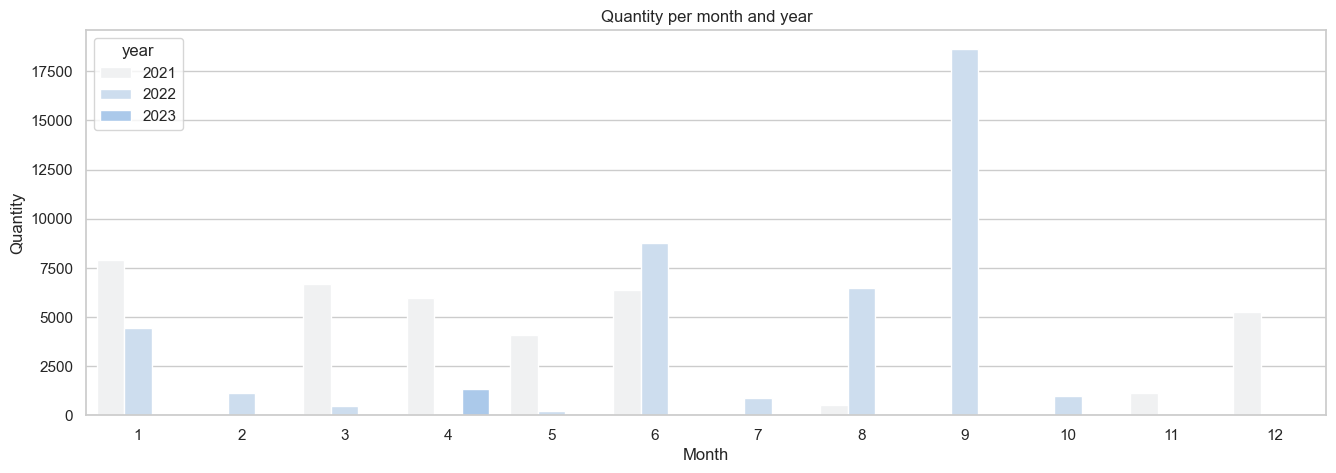

In [36]:
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(x=quantity_per_warehouse['month'], y=quantity_per_warehouse['Order Quantity'], hue=quantity_per_warehouse['year'], color='b', ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("Quantity")
ax.set_title("Quantity per month and year");

In [37]:
sku_product = df_sales_data[df_sales_data['SKU ID']=='3619CA']
quantity_per_warehouse = sku_product.groupby(['SKU ID', 'Warehouse ID'])['Order Quantity'].sum().reset_index()
quantity_per_warehouse.sort_values(by='SKU ID', ascending=False)

,SKU ID,Warehouse ID,Order Quantity
0,3619CA,AXW291,217295
1,3619CA,FLR025,85459
2,3619CA,GUT930,120088
3,3619CA,NXH382,81307


In [38]:
quantity_per_warehouse = sku_product.groupby(['SKU ID', 'Warehouse ID', 'month', 'year'])['Order Quantity'].sum().reset_index()
quantity_per_warehouse.sort_values(by=['year', 'month'], ascending=True).head(20)

,SKU ID,Warehouse ID,month,year,Order Quantity
0,3619CA,AXW291,1,2021,6560
45,3619CA,GUT930,1,2021,2845
65,3619CA,NXH382,1,2021,7890
3,3619CA,AXW291,2,2021,5425
29,3619CA,FLR025,2,2021,5000
46,3619CA,GUT930,2,2021,6444
67,3619CA,NXH382,2,2021,60
5,3619CA,AXW291,3,2021,7375
48,3619CA,GUT930,3,2021,12620
69,3619CA,NXH382,3,2021,6663


## Transforming data for Model

### Dropping the unnecessary columns

In [39]:
df_inventory.drop(['SKU ID', 'Vendor Name', 'Warehouse ID',
       'Cost per SKU', 'Total Value', 'Units (Nos/Kg)',
       'Average Lead Time (days)', 'Maximum Lead Time (days)', 'Unit Price',
       'Avg Sales Per Day', 'Max Sales Per Day', 'Optimal Stock Level',
       'Safety Stock'],axis=1,inplace=True)

### creating a new feature

In [40]:
df_inventory['Action'] = 'No Action'
df_inventory.loc[df_inventory['Order Quantity'] > 0, 'Action'] = 'Increase Supply'
df_inventory.loc[df_inventory['Order Quantity'] < 0, 'Action'] = 'Reduce Supply'

### Splitting the input and output

In [41]:
X = df_inventory.drop('Action', axis=1)
y = df_inventory['Action']

### how big is our data

In [43]:
print(X.shape)
print(y.shape)

(8710, 3)
(8710,)


### Label encoding

In [44]:
le = preprocessing.LabelEncoder()

y = le.fit_transform(y)

### TRAIN/TEST SPLIT

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### scaling the data

In [46]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the scaled features
X_train_scaled[:5, :]

array([[-0.33251807, -0.21152118, -0.18935144],
       [-0.34369936, -0.2105291 , -0.18626271],
       [-0.32679106, -0.21275945, -0.18951358],
       [-0.30161044, -0.21304972, -0.18951358],
       [-0.26611212, -0.21085979, -0.18951358]])

### Random Forest

In [47]:
# Initialize the model (Random Forest Regressor)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [48]:
predictions = model.predict(X_test_scaled)

## EVALUATION**
 

### confusion matrix

In [49]:
cm = confusion_matrix(y_test,predictions)
print(cm)

[[1598    0]
 [   0 1015]]


### classification report

In [50]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1598
           1       1.00      1.00      1.00      1015

    accuracy                           1.00      2613
   macro avg       1.00      1.00      1.00      2613
weighted avg       1.00      1.00      1.00      2613



# LOGISTIC OPTIMIZATION

## IMPORTING LIBRARIES

In [53]:
import osmnx as ox
import networkx as nx
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## IMPORT MAPS

In [54]:
G = ox.graph_from_place('New York City, New York', network_type='drive')

## SEPERATING THE EDGES AND NODES

In [55]:
edges = ox.graph_to_gdfs(G, nodes=False)['geometry']
X = np.array([edge.length for edge in edges]).reshape(-1, 1)  
y = np.array([edge.get('length') for u, v, edge in G.edges(data=True)])

## SPLITING THE DATA INTO TRAIN TEST

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## MODELING

In [57]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## EVALUATION


In [58]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 219.96984660070254


## INITIALIZING NODES

In [59]:
#(latitude, longitude)

start_node = (40.5795, -74.1502)  
end_node = (40.7306, -73.9352) 

## MAPPING THE NODES WITH GRAPH

In [60]:
start_node = ox.distance.nearest_nodes(G, start_node[1], start_node[0])
end_node = ox.distance.nearest_nodes(G, end_node[1], end_node[0])

## CALCULATING DISTANCE

In [61]:
edge_length = model.predict(np.array([[ox.distance.euclidean_dist_vec(G.nodes[start_node]['y'], G.nodes[start_node]['x'], G.nodes[end_node]['y'], G.nodes[end_node]['x'])]]))[0]

## VISUALIZATIONS

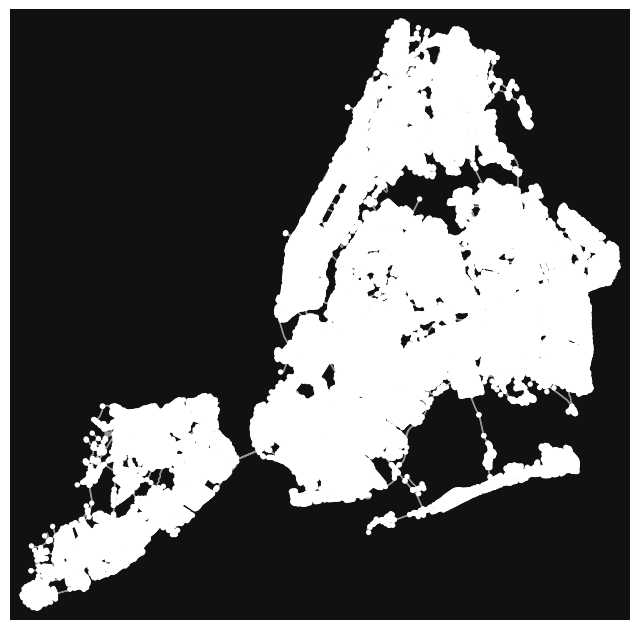

In [62]:
fig, ax = ox.plot_graph(G, show=False, close=False)

In [63]:
route = nx.shortest_path(G, source=start_node, target=end_node, weight='length')

## HIGHLIGHTING THE OPTIMAL PATH

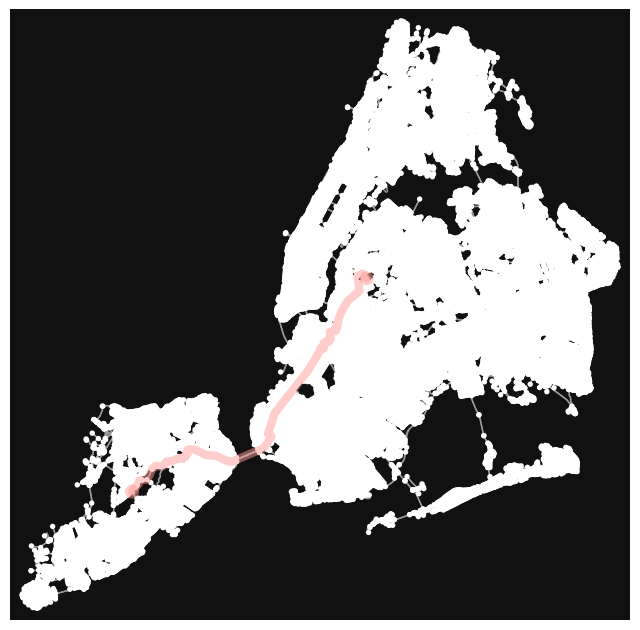

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [64]:
ox.plot_graph_route(G, route, route_linewidth=6, route_color='r', route_alpha=0.5)


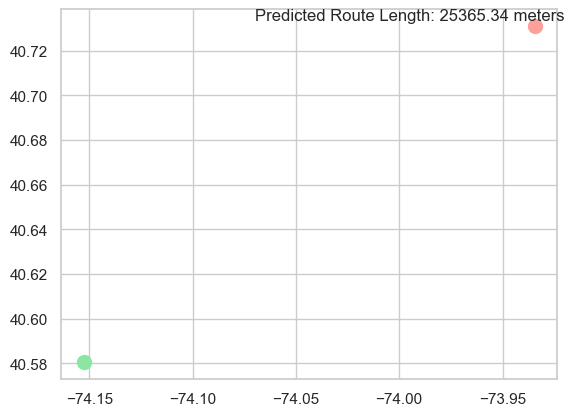

In [65]:
plt.scatter(G.nodes[start_node]['x'], G.nodes[start_node]['y'], c='g', s=100, zorder=3)
plt.scatter(G.nodes[end_node]['x'], G.nodes[end_node]['y'], c='r', s=100, zorder=3)
plt.text(0.5, 0.5, f'Predicted Route Length: {edge_length:.2f} meters', transform=ax.transAxes, fontsize=12, ha='center')
plt.show()